## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 5 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

reduce_lr_factor = [0.25,0.5]
redice_lr_patient = [5,10]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor,
                                 min_lr=1e-12,
                                 monitor='val_loss',
                                 patience=5,
                                 verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.25, reduce_patient: 5
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
b

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 3s 52us/step - loss: 2.1967 - accuracy: 0.2720 - val_loss: 2.1127 - val_accuracy: 0.2222
Epoch 2/5
50000/50000 [==============================] - 2s 39us/step - loss: 1.7377 - accuracy: 0.3914 - val_loss: 1.9493 - val_accuracy: 0.3097
Epoch 3/5
50000/50000 [==============================] - 2s 40us/step - loss: 1.6154 - accuracy: 0.4326 - val_loss: 1.8091 - val_accuracy: 0.3686
Epoch 4/5
50000/50000 [==============================] - 2s 40us/step - loss: 1.5437 - accuracy: 0.4585 - val_loss: 1.7034 - val_accuracy: 0.4100
Epoch 5/5
50000/50000 [==============================] - 2s 39us/step - loss: 1.4913 - accuracy: 0.4778 - val_loss: 1.6364 - val_accuracy: 0.4333
Numbers of exp: 4, reduce_factor: 0.25, reduce_patient: 5
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (Inpu

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 3s 56us/step - loss: 1.8231 - accuracy: 0.3601 - val_loss: 5.3603 - val_accuracy: 0.1537
Epoch 2/5
50000/50000 [==============================] - 2s 42us/step - loss: 1.5734 - accuracy: 0.4396 - val_loss: 2.1744 - val_accuracy: 0.3020
Epoch 3/5
50000/50000 [==============================] - 2s 41us/step - loss: 1.4781 - accuracy: 0.4752 - val_loss: 1.6471 - val_accuracy: 0.4137
Epoch 4/5
50000/50000 [==============================] - 2s 45us/step - loss: 1.4118 - accuracy: 0.4992 - val_loss: 1.7114 - val_accuracy: 0.3894
Epoch 5/5
50000/50000 [==============================] - 2s 43us/step - loss: 1.3524 - accuracy: 0.5186 - val_loss: 1.5798 - val_accuracy: 0.4342
Numbers of exp: 8, reduce_factor: 0.25, reduce_patient: 5
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (Inpu

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 3s 54us/step - loss: 1.8126 - accuracy: 0.3716 - val_loss: 2.5983 - val_accuracy: 0.1778
Epoch 2/5
50000/50000 [==============================] - 2s 40us/step - loss: 1.5395 - accuracy: 0.4549 - val_loss: 2.0553 - val_accuracy: 0.3013
Epoch 3/5
50000/50000 [==============================] - 2s 39us/step - loss: 1.4386 - accuracy: 0.4922 - val_loss: 2.1698 - val_accuracy: 0.3159
Epoch 4/5
50000/50000 [==============================] - 2s 39us/step - loss: 1.3628 - accuracy: 0.5174 - val_loss: 1.8916 - val_accuracy: 0.3365
Epoch 5/5
50000/50000 [==============================] - 2s 39us/step - loss: 1.3092 - accuracy: 0.5377 - val_loss: 2.1233 - val_accuracy: 0.3088


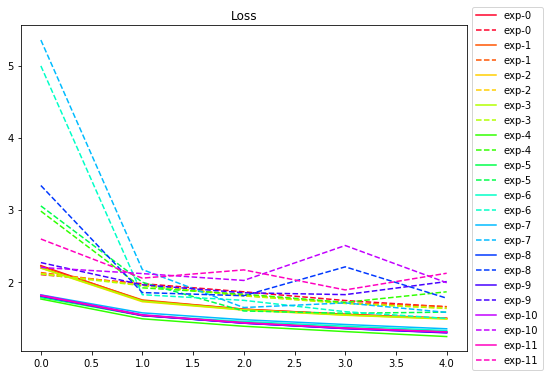

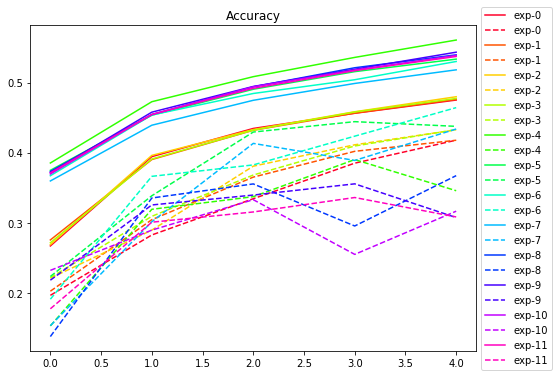

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()